In [ ]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

num_epochs = 100
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Softmax(),
            )
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().cpu()
distance = nn.MSELoss()
#distance = nn.BCELoss()
#distance = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cpu()
        output = model(img)
        loss = distance(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [16]:
import numpy as np
np.set_printoptions(suppress=True)

confusion_matrix = np.zeros((10, 10))

batch_size = 20*1000

testset = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

for data in dataloader:
    imgs, labels = data
    imgs = Variable(imgs).cpu()
    encs = model.encoder(imgs).detach().numpy()
    for i in range(len(encs)):
        predicted = np.argmax(encs[i])
        actual = labels[i]
        confusion_matrix[actual][predicted] += 1
print(confusion_matrix)
print(int(confusion_matrix.sum()))

[[383. 186.  22. 326.  31.  21.   3.   0.   7.   1.]
 [  0.   0.  39.   3.   0.   0.  73.   4. 197. 819.]
 [  2. 203.  88. 171.  50.   4.  13. 256. 156.  89.]
 [ 27.   0.  20. 882.   3.   0.  13.  21.  20.  24.]
 [ 61.  79.  22.   0.   0.  29. 528.  47.  11. 205.]
 [ 60.   0.  74. 494.   0. 108.  12.   4.  28. 112.]
 [ 16.  16.  87.   1.   6. 103.  23.  50. 655.   1.]
 [148.   0.   0.   0.   1.   0. 366.   7.   2. 504.]
 [  4.   5.  56. 594.   6.   7.  18.  16.   3. 265.]
 [ 59.   8.   3.  29.   2.   7. 609.   1.   0. 291.]]
10000


In [18]:
active_neurons = set()
for actual in range(10):
    predicted = np.argmax(confusion_matrix[actual])
    pct = 100 * confusion_matrix[actual][predicted] / np.sum(confusion_matrix[actual])
    print('Actual label %d most likely activates on neuron %d (%d%%)' % (actual, predicted, pct))
    active_neurons.add(predicted)
active_neurons, len(active_neurons)

Actual label 0 most likely activates on neuron 0 (39%)
Actual label 1 most likely activates on neuron 9 (72%)
Actual label 2 most likely activates on neuron 7 (24%)
Actual label 3 most likely activates on neuron 3 (87%)
Actual label 4 most likely activates on neuron 6 (53%)
Actual label 5 most likely activates on neuron 3 (55%)
Actual label 6 most likely activates on neuron 8 (68%)
Actual label 7 most likely activates on neuron 9 (49%)
Actual label 8 most likely activates on neuron 3 (60%)
Actual label 9 most likely activates on neuron 6 (60%)


({0, 3, 6, 7, 8, 9}, 6)

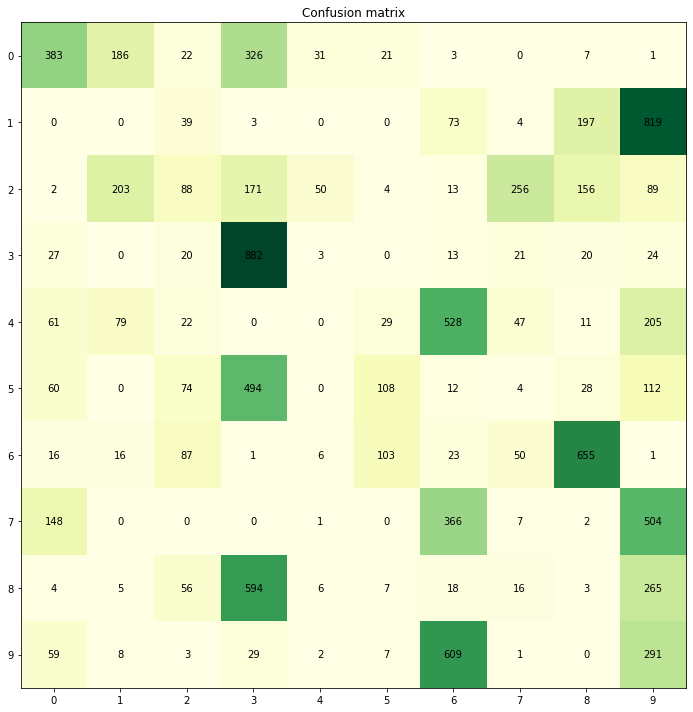

In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="YlGn")
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_title("Confusion matrix")
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, int(confusion_matrix[i, j]),
                       ha="center", va="center")
fig.tight_layout()
plt.show()

In [34]:
classifier = {
    # enc -> predict
    0: 0,
    1: 2,
    2: 2,
    3: 3,
    4: 2,
    5: 5,
    6: 9,
    7: 2,
    8: 6,
    9: 1,
}

testset = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)
total = 0
correct = 0
for data in dataloader:
    imgs, labels = data
    imgs = Variable(imgs).cpu()
    encs = model.encoder(imgs).detach().numpy()
    for i in range(len(encs)):
        predicted = classifier[np.argmax(encs[i])]
        actual = labels[i]
        if predicted == actual:
            correct += 1
        total += 1
print(confusion_matrix)
print(int(confusion_matrix.sum()))

print(correct/total)

[[383. 186.  22. 326.  31.  21.   3.   0.   7.   1.]
 [  0.   0.  39.   3.   0.   0.  73.   4. 197. 819.]
 [  2. 203.  88. 171.  50.   4.  13. 256. 156.  89.]
 [ 27.   0.  20. 882.   3.   0.  13.  21.  20.  24.]
 [ 61.  79.  22.   0.   0.  29. 528.  47.  11. 205.]
 [ 60.   0.  74. 494.   0. 108.  12.   4.  28. 112.]
 [ 16.  16.  87.   1.   6. 103.  23.  50. 655.   1.]
 [148.   0.   0.   0.   1.   0. 366.   7.   2. 504.]
 [  4.   5.  56. 594.   6.   7.  18.  16.   3. 265.]
 [ 59.   8.   3.  29.   2.   7. 609.   1.   0. 291.]]
10000
0.4053
